# Statistical properties of the promoter library
## Introduction

The statistical analysis generates visualizations for sequence specific properties like the histogram of sequence distance with respect to nucleotide exchanges, and the diversity of position specific sampling using entropy. The expression for the expression is given by a histogram of the expression strength distribution. The joint information of sequence and expression is visualized with heat-maps on average and variance of expression.

The visualizations are stored in a subdirectory with a naming corresponding to the input file, see 'config.txt'.

---

**Author: Ulf W. Liebal** <br>
**Contact: ulf.liebal@rwth-aachen.de** <br>

---

## System initiation

Loading all necessary libraries.

In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from exp2ipynb import *

%matplotlib inline

### Variable setting

We load the naming conventions and parameters for statistical analysis and regression from 'config.txt'

In [2]:
Name_Dict = init_Exp2('config_Pput.txt')

ML_Date = Name_Dict['ML_Date']
File_Base = Name_Dict['Data_File'].split('.')[0]
Data_Folder = 'data-{}'.format(File_Base) 
Measure_Numb = int(Name_Dict['Library_Expression'])
ML_Regressor = Name_Dict['ML_Regressor'][:-1]
ML_Type = Name_Dict['ML_Regressor'][-1]
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
Response_Value = eval(Name_Dict['Response_Value'])
Entropy_cutoff = eval(Name_Dict['Entropy_cutoff'])
Fig_Type = Name_Dict['Figure_Type']
FigFontSize = Name_Dict['Figure_Font_Size']


Already existent data directory  data-Example1-Pput .


## Data loading

General information on the data source csv-file, like the target variable name and units, are stored in the 'config.txt' file generated in the '0-Workflow' notebook. The sequence and expression data is stored in a csv file with a column with IDs for each sequence (user defined), the DNA-sequence in column 'Sequence' (obligatory), and the expression strength in column with a name define in the `config.txt`. While loading, the sequence is converted to a label encrypted sequence, ['A','C','G','T'] replaced by [0,1,2,3], and a one-hot encoding and the GC content is calculated. 

In [3]:
SeqDat = Data_Src_Load(Name_Dict)
# some statistical information of the samples
Samples_ValCount = SeqDat['Sequence_letter-encrypted'].value_counts()
Num_UniqueSamples = len(Samples_ValCount)
Median_ReplicateNumber = np.median(list(dict(Samples_ValCount).values()))
Min_ReplicateNumber = np.min(list(dict(Samples_ValCount).values()))
Max_ReplicateNumber = np.max(list(dict(Samples_ValCount).values()))

print('Statistical information of input sequence:')
print('Unique samples: {}'.format(Num_UniqueSamples))
print('Number of replicates: min: {} - median: {} - max: {}'.format(Min_ReplicateNumber, Median_ReplicateNumber, Max_ReplicateNumber))
SeqDat.head(3)

Following outliers were detected: ID: ['BGSPL14g_19_a'], Value: [[50.13234789]]
Categorization of expression.
The expression values were sorted into the following bins: [ 0.2178722  16.5660553  24.76999231 35.15239853]
Statistical information of input sequence:
Unique samples: 63
Number of replicates: min: 1 - median: 1.0 - max: 1


,level_0,index,Strain ID,Sequence,Promoter Activity,Sequence_label-encrypted,Sequence_letter-encrypted,GC-content,Promoter Activity_ML
0,0,0,BG14g,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",35.057893,"[2, 1, 1, 1, 0, 3, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG,0.575,2
1,12,12,BGSPL14g_01_a,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",2.185554,"[2, 1, 1, 1, 0, 0, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCAATGACAAGGCTCTCGCGGCCAGGTATAATTGCACG,0.575,0
2,22,22,BGSPL14g_01_c,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",1.383577,"[2, 1, 1, 1, 0, 1, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCACTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG,0.600,0


## Data manipulation

### Position entropy analysis

On each position the entropy is calculated to assess how much nucleotide diversity has been sampled on each position.  

## Visualization of statistical properties

The standardized expression is used for visualization of the average and variance of expression for each nucleotide on each position (Heat map visualization of nucleotide-position expression). A histogram of the sequence differences is generated. Here, the frequency of sequences with a given number of nucleotide exchanges (in %) relative to the first sequence is plotted (Histogram of sequence distances). The sampled nucleotide diversity on each sequence position is plotted (Position entropy lollipop). A histogram showing the number of sequences over the expression range with a binning of ten is shown (Expression strength histogram).

### Heat map visualization of nucleotide-position expression

The heat maps are visualized only and not saved. Visualization of variation is suppressed.

Promoter Activity_ML


/home/ulf/anaconda3/envs/exp2ipynb/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


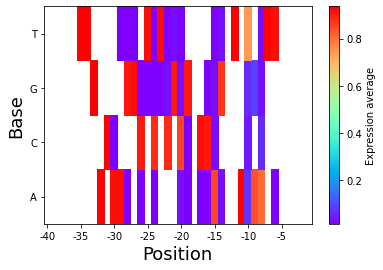

In [4]:
# standardization step, omit for CART approaches by setting variable 'Data_Standard' to 'False'
# if eval(Name_Dict['Data_Standard']):
#     SeqDat, Expr_Scaler = ExpressionScaler(SeqDat, Name_Dict)

# removing non-informative positions where no base diversity exists, base one hot encoding
SeqDat_Hadj, Positions_removed, PSEntropy = Sequence_Conserved_Adjusted(SeqDat, Name_Dict, Entropy_cutoff=0)

Measurements = int(Name_Dict['Library_Expression'])
SeqPos = len(PSEntropy)
# The mean values of position dependent expression contribution are stored in an array to compute the standard deviation among all measurements
# The standard deviation is a metric how similar the effect is of a base at a position
Expr_array = np.empty([SeqPos, 4, Measurements], dtype=float)

# we loop over all independent expression measurements
for idx in range(Measurements):
#     if eval(Name_Dict['Data_Standard']):
    Measure_Name = '{}_ML'.format(Y_Col_Name[idx])    
#     else:
#         Measure_Name = Y_Col_Name[idx]
    print(Measure_Name)
# # removing non-informative positions where no base diversity exists, base one hot encoding
    Expr_avg = ExpressionStrength_HeatMap(SeqDat_Hadj, Measure_Name) #Expression_Column)
    Expr_avg = Insert_row_(Positions_removed, Expr_avg, np.zeros([len(Positions_removed),4])*np.nan)
    Expr_array[:,:,idx] = Expr_avg.values
# visualization of variation is commented
    Expr_var = ExpressionVariation_HeatMap(SeqDat_Hadj, Measure_Name)
#     Expr_var = Insert_row_(Positions_removed, Expr_var, np.zeros([len(Positions_removed),4])*np.nan)
    Fig_ID = Name_Dict['HM_File']
    HM_File = os.path.join(Data_Folder, '{}_{}_{}_{}_{{}}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Measure_Name.replace(' ',''), Fig_Type))   

    # if you want to store the heat-maps switch the argument 'False' to 'True'
    df_HeatMaps(Expr_avg, 'Expression average', True, HM_File.format('Average'), cbar_lab=None, FigFontSize=Name_Dict['Figure_Font_Size'])
#     df_HeatMaps(Expr_var, 'Expression variance', True, HM_File.format('Variance'), cbar_lab=None, FigFontSize=FigFontSize)

Expr_array = np.delete(Expr_array, Positions_removed, axis=0)
if eval(Name_Dict['Response_Value']) == 0 and len(Y_Col_Name) == 2:
    print('The variance plot identifies the positions on which bases have a statistically divergent effect on activity.')
    print('Only positions are shown that display a significant difference of the mean based on a Welsh\'s t-test.')
    Measure_Name = ['{}_ML'.format(MeasName) for MeasName in Y_Col_Name]
    #performing Students t-test for significant differences in the mean value of expression for each base on all positions
    AllDat = np.array([SeqDat_Hadj[lookup].values for lookup in Measure_Name])
    Ttest_result = ExpressionMean_ttest(AllDat[0,:], AllDat[1,:], list(SeqDat_Hadj['OneHot']))
    # Calculating the variance between multi-library measurements
    # A large cv shows divergent effects of bases on defined positions
    Expression_var = pd.DataFrame(np.var(Expr_array, axis=2), columns=['A','C','G','T'])
    # removing elements with insignificant mean separation
    Expression_var_sig = Expression_var.div(Ttest_result.values, level=1, fill_value=0)
    Expr_var_sig = Insert_row_(Positions_removed, Expression_var_sig, np.empty([len(Positions_removed),4]))
    HM_File = os.path.join(Data_Folder, '{}_{}_{}_{{}}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))   
    df_HeatMaps(Expr_var_sig, 'Variance', Plot_Save=True, Plot_File=HM_File.format('Variance'))
    

### Histogram of sequence distances

The histograms can be calculated in two ways:
 * sequence distances relative to a reference sequence
 * sequence distances among all sequences
The sequence distance relative to a reference sequence makes sense if the library is generated from a single reference promoter set-up. The calculation is fast. If the library is very heterogeneous and different reference promoters have been used, then it is more appropriate to compare all sequences against each other to identify the overall sampled sequence diversity. The occurence takes high values because all sequences are mutually paired. This takes longer to compute (still less than a minute for fewer than 1000 samples of sequence length 50).

**User input:** <br>
 * Decision for sequence distance with respect to reference seuqence or among all sequences.
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.
 
*Example:*<br>
In the *P. putida* example, a single reference promoter sequence is used. Therefore, the reference based sequence distance meter is appropriate:<br>
mydist = Sequence_Ref_DiffSum(SeqDat['Sequence_letter-encrypted'])

A generic file name for figure export is set, but figure-export to svg is commented.


Complete sequence distances.
Average distance: 0.06


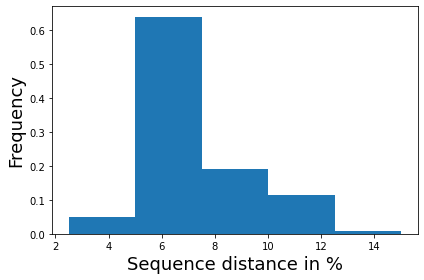

In [5]:
# For histogram of sequence diversity you can either root the distance to the most common nucleotide on each position or provide an external reference
mydist = generate_distances(SeqDat, Name_Dict, Hist_Type=0)
print('Average distance: {:.2f}'.format(np.mean(mydist)))
# plt.rc('text', usetex=False)
plt.hist(mydist*100, bins=5, weights=np.zeros_like(mydist) + 1. / mydist.size) # BG42: [3,6:221]; BG35:[2,222:]
plt.xlabel('Sequence distance in %', fontsize=FigFontSize)
plt.ylabel('Frequency', fontsize=FigFontSize)
plt.tight_layout()
Fig_ID = Name_Dict['SampSeqDist_File']
SampSeqDist_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(SampSeqDist_File, bbox_inches='tight', format=Fig_Type)
plt.show()

### Position sampling and entropy lollipop

**User input:** <br>
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.


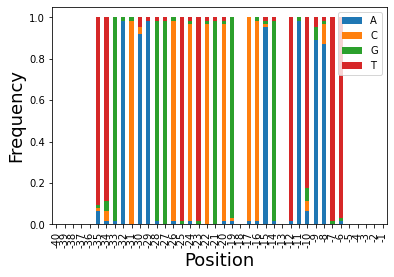

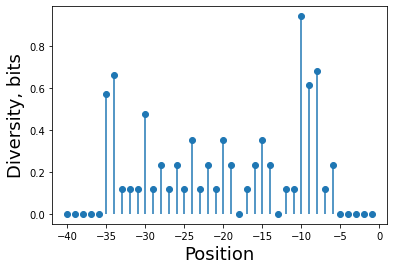

In [6]:
# stacked histogram of number of each nucleotide per position
OH_matrix = np.stack(SeqDat_Hadj['OneHot'].values)
OH_df = pd.DataFrame(np.sum(OH_matrix, axis=0)/len(SeqDat_Hadj), columns=['A','C','G','T'])
OH_df = Insert_row_(Positions_removed, OH_df, np.zeros([len(Positions_removed),4]))
OH_df[['A','C','G','T']].plot(kind='bar', stacked=True)
# ax.set_xticklabels(rotation=0, fontsize=16)
# plt.tick_params(axis='x', labelsize=18)
plt.xlabel('Position', fontsize=FigFontSize)
plt.ylabel('Frequency', fontsize=FigFontSize)

Fig_ID = Name_Dict['SamplingDiv_File']
SamplingDiv_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(SamplingDiv_File, bbox_inches='tight', format=Fig_Type)
plt.show()

# entropy on each position
plt.stem(np.arange(-len(PSEntropy),0,1), PSEntropy, basefmt=' ', use_line_collection=True)
plt.xlabel('Position', fontsize=FigFontSize)
plt.ylabel('Diversity, bits', fontsize=FigFontSize)
Fig_ID = Name_Dict['Entropy_File']
Entropy_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(Entropy_File, bbox_inches='tight', format=Fig_Type)
plt.show()

### Expression strength histogram

**User input:** <br>
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.


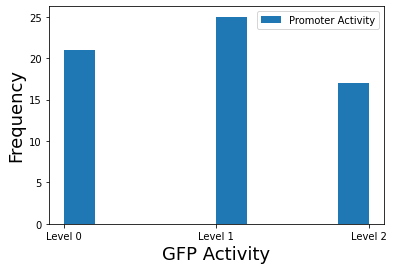

In [7]:
# deciding whether to plot histogram of measured expression or categorized values
# if ML_Type == 'C':
#     Measures = ['{}_Cat'.format(Meas) for Meas in Y_Col_Name]
# else:
#     Measures = Y_Col_Name
import seaborn as sns

Measures = ['{}_ML'.format(Meas) for Meas in Y_Col_Name]
ExprData = SeqDat[Measures].values

plt.hist(ExprData)
plt.xlabel(Name_Dict['Expression_Unit'], fontsize=FigFontSize)
if Response_Value > 1:
    plt.xticks([0,1,2], ['Level {}'.format(myval) for myval in range(Response_Value)])
plt.ylabel('Frequency', fontsize=FigFontSize)
plt.legend(Y_Col_Name)
Fig_ID = Name_Dict['ExprHist_File']
ExprHist_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(ExprHist_File, bbox_inches='tight', format=Fig_Type)
plt.show()

## Promoter cross-host expression (optional)

In case the promoter library was constructed such that a sequence library was tested in different organisms (transcription factors) then it is instructive to compare cross-host (cross-transcription factor) expression strength. Here, this is only done for two measurements.

In [ ]:
if len(Y_Col_Name) == 2:
    Measure_Name = ['{}_ML'.format(MeasName) for MeasName in Y_Col_Name]
    ExprRange_1 = SeqDat[Measure_Name[0]]#/SeqDat[Y_Col_Name[0]].max()*100
    ExprRange_2 = SeqDat[Measure_Name[1]]#/SeqDat[Y_Col_Name[1]].max()*100

    fig = plt.figure()
#     ax = fig.gca()
#     ax.set_xticks(np.arange(0, 100, 10))
#     ax.set_yticks(np.arange(0, 100, 10))


    plt.plot(ExprRange_1, ExprRange_2, 'xk')
    plt.xlabel('{}, {}'.format(Measure_Name[0], Name_Dict['Expression_Unit']), fontsize=FigFontSize)
    plt.ylabel('{}, {}'.format(Measure_Name[1], Name_Dict['Expression_Unit']), fontsize=FigFontSize)
    plt.title('Cross Expression Translation')
    plt.grid()
    plt.tight_layout()
    Fig_ID = Name_Dict['X_Expr']
    XExpr_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
    plt.savefig(XExpr_File, bbox_inches='tight', format=Fig_Type)
    plt.show()
else:
    print('Cross-host expression visualization not possible.')